In [1]:
import requests
from bs4 import BeautifulSoup
import os
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time

from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def elec_year(year): 
    os.makedirs(f'elec_demand_{year}',exist_ok=True)
    chromedriver_path = r'D:\pythonproject\chromedriver.exe'
    download_dir = f'd:\\pythonproject\\Stat\\FTS-MDH\\dataset_elec\\elec_demand_{year}'

    options = webdriver.ChromeOptions()
    prefs = {'download.default_directory': download_dir}
    options.add_experimental_option('prefs', prefs)
    driver = webdriver.Chrome(service=Service(chromedriver_path), options=options)

    for month in range(1, 13):
        for day in range(1, 32):
            url = f'https://demanda.ree.es/visiona/peninsula/nacionalau/tablas/{year}-{month:02d}-{day:02d}/1'


            driver.get(url)

            try:
                # 等待页面加载
                time.sleep(2)

                # 关闭 Cookie 弹窗（如果有）
                try:
                    cookie_btn = WebDriverWait(driver, 3).until(
                        EC.element_to_be_clickable((By.ID, "CybotCookiebotDialogBodyLevelButtonLevelOptinAllowAll"))
                    )
                    cookie_btn.click()
                    time.sleep(1)
                except Exception:
                    pass  # 没有弹窗则跳过

                # 等待并点击CSV下载按钮
                try:
                    csv_button = WebDriverWait(driver, 3).until(
                        EC.element_to_be_clickable((By.CSS_SELECTOR, 'a[ng-click^="csvGeneration"]'))
                    )
                    csv_button.click()
                    time.sleep(2)
                    print(f'{url} 下载完成，请在下载目录查看文件。')
                except TimeoutException:
                    print(f'{url} 页面不存在或无下载按钮，已跳过')
                
            except Exception as e:
                print(f'{url} 下载过程中出现错误: {e}')

    driver.quit()
            

In [2]:
for year in range(2020,2023):
    elec_year(year)

NameError: name 'elec_year' is not defined

In [3]:
files=os.listdir(r'D:\pythonproject\Stat\FTS-MDH\dataset_elec\elec_demand_2024')
filespath = [os.path.join(r'D:\pythonproject\Stat\FTS-MDH\dataset_elec\elec_demand_2024', file) for file in files]
data={}
for file in filespath:
    demand=pd.read_csv(file,
                header=None,
                encoding='utf-8',
                names=['datetime','demand','forest','scheduled'],
                skiprows=3,
                index_col=False
                )
    demand[['date','time']]=demand['datetime'].str.split(' ', expand=True)
    day= demand['date'].iloc[0]
    data[f'{day}']=demand
    

In [4]:
all_df = pd.concat(data.values(), ignore_index=True)
all_df = all_df.dropna(subset=['demand'])

# Remove duplicate datetime values in all_df, keeping the first occurrence
all_data = all_df.drop_duplicates(subset=['datetime'])

# Remove rows where 'date' is '2023-12-31' or '2025-01-01'
all_data = all_data[~all_data['date'].isin(['2023-12-31', '2025-01-01'])]

all_data=all_data.reset_index(drop=True)

all_data

datetime  demand  forest  scheduled        date   time
0       2024-01-01 00:00   23548   23601      23580  2024-01-01  00:00
1       2024-01-01 00:05   23578   23489      23580  2024-01-01  00:05
2       2024-01-01 00:10   23612   23408      23580  2024-01-01  00:10
3       2024-01-01 00:15   23495   23356      23603  2024-01-01  00:15
4       2024-01-01 00:20   23393   23328      23603  2024-01-01  00:20
...                  ...     ...     ...        ...         ...    ...
105683  2024-12-31 23:35   25599   25540      25604  2024-12-31  23:35
105684  2024-12-31 23:40   25498   25469      25604  2024-12-31  23:40
105685  2024-12-31 23:45   25388   25413      25204  2024-12-31  23:45
105686  2024-12-31 23:50   25240   25354      25204  2024-12-31  23:50
105687  2024-12-31 23:55   25012   25273      25204  2024-12-31  23:55

[105688 rows x 6 columns]

In [5]:
group_day=all_data.groupby('date')
demand_day=np.zeros((len(all_data['date'].unique()),288))
for i, (day,group) in enumerate(group_day):
    if group.shape[0]==288:
        demand_day[i]=group['demand']
    else: 
        pass

demand_day = demand_day[~np.all(demand_day == 0, axis=1)]

demand_day

array([[23548., 23578., 23612., ..., 24367., 24195., 23889.],
       [23720., 23690., 23543., ..., 27809., 27408., 27289.],
       [26913., 26958., 26992., ..., 27903., 27618., 27372.],
       ...,
       [24826., 24787., 24769., ..., 25936., 25724., 25715.],
       [25255., 24956., 24852., ..., 23730., 23560., 23492.],
       [23224., 23199., 23041., ..., 25537., 25352., 24974.]],
      shape=(365, 288))

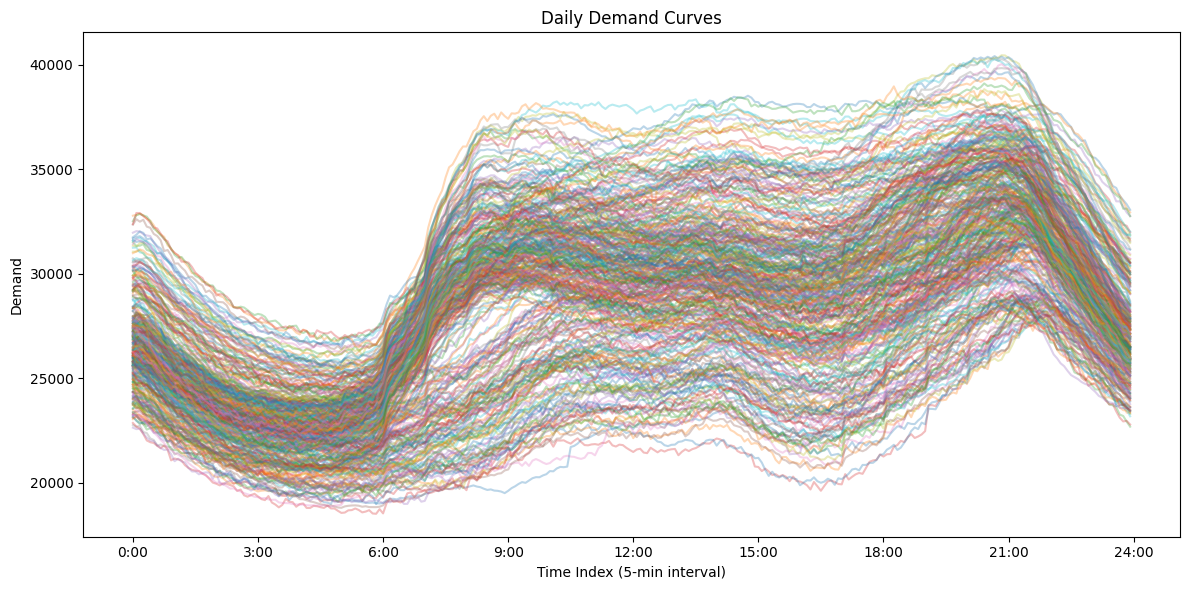

In [6]:
# 假设demand_day的shape为 (天数, 288)，每行是一天，每列是一天中的一个时刻
plt.figure(figsize=(12, 6))
for i in range(demand_day.shape[0]):
    plt.plot(np.arange(288), demand_day[i], alpha=0.3)
plt.xlabel('Time Index (5-min interval)')
plt.ylabel('Demand')
plt.title('Daily Demand Curves')
plt.xticks(np.arange(0, 289, 36), [f'{h}:00' for h in range(0, 25, 3)])  # 每3小时一个刻度
plt.tight_layout()
plt.show()



In [7]:
import sys
import os
sys.path.append(os.path.abspath('..'))
from fts_mds import *
from all_test import *

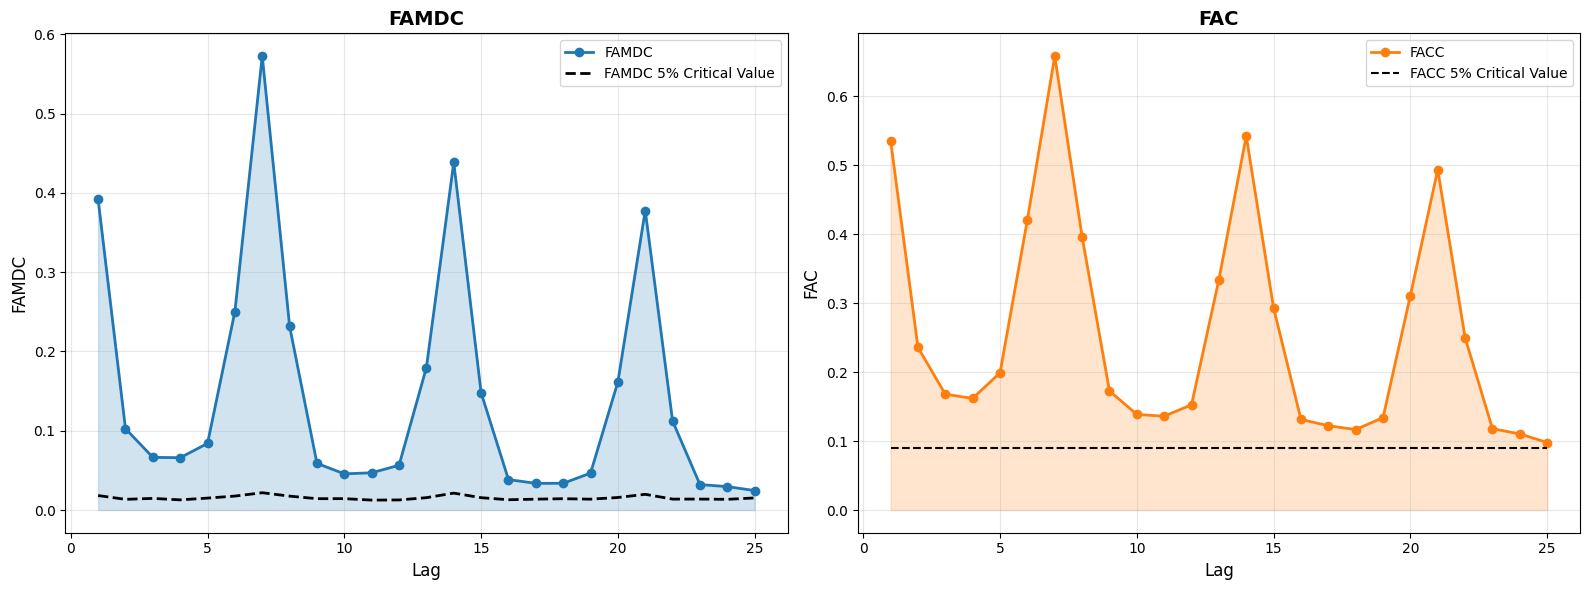

In [15]:
N=365
nboot=299
nlag=25

# 标准化
#smooth the functional data 
fd_grid = FDataGrid(demand_day)
basis = FourierBasis(domain_range=(0, 1), n_basis=20) # Create Fourier basis
fd_basis = fd_grid.to_basis(basis)

p3 = np.linspace(0, 1, 1001)
fd3 = fd_basis(p3).squeeze()
data3_ts=torch.tensor(fd3).cuda()
#generate bootstrap weights
weights=w_t(nboot,N=N)
wt_ts=torch.from_numpy(weights).cuda()
wt_mat=wt_ts.unsqueeze(2)*wt_ts.unsqueeze(1)


res=np.zeros((2,nlag))
for lag in range(1,nlag+1):
    FAMDC=compute_FAMDC_nj(data3_ts,N,lag)
    res[0, lag-1] = FAMDC.cpu().item()
    cors=veccor(data3_ts,wt_mat,N,lag)
    res[1, lag-1]=torch.quantile(cors,1-0.05).cpu()


res_facc=np.zeros(nlag)
for lag in range(1,nlag+1):
    res_facc[lag-1] =facc(fd3,lag,N)


critical=facc_crit(fd3,N)*np.ones(nlag)

lags = np.arange(1, nlag + 1)
# 方案1: 两个子图并排比较
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 左图: FAMDC
ax1.plot(lags, res[0], marker='o', label='FAMDC', linewidth=2, markersize=6,color='C0')
ax1.fill_between(lags, res[0], alpha=0.2,color='C0')
ax1.plot(lags, res[1], 'k--', label='FAMDC 5% Critical Value', linewidth=2)
ax1.set_xlabel('Lag', fontsize=12)
ax1.set_ylabel('FAMDC', fontsize=12)
ax1.set_title('FAMDC', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 右图: FACC
ax2.plot(lags, res_facc, marker='o', label='FACC', linewidth=2, markersize=6,color='C1')
ax2.fill_between(lags, res_facc, alpha=0.2,color='C1')
ax2.plot(lags, critical , 'k--', label='FACC 5% Critical Value')
ax2.set_xlabel('Lag', fontsize=12)
ax2.set_ylabel('FAC', fontsize=12)
ax2.set_title('FAC', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:


# Parameters
N=demand_day.shape[0]
nboot=299
alpha=np.array([0.01,0.05,0.1])


#smooth the functional data 
fd_grid = FDataGrid(demand_day)
basis = FourierBasis(domain_range=(0, 1), n_basis=20) # Create Fourier basis
fd_basis = fd_grid.to_basis(basis)

# Evaluate the function with different grid
p1 = np.linspace(0, 1, 101)
p2 = np.linspace(0, 1, 51)
p3 = np.linspace(0, 1, 1001)

fd1 = fd_basis(p1).squeeze()
fd2 = fd_basis(p2).squeeze()
fd3 = fd_basis(p3).squeeze()

p_values=np.zeros(10)
############################################### test
""" HHR Test"""
rej_HHR10,p_v10=test_HHR(fd1,N,alpha,H=10)
rej_HHR30,p_v30=test_HHR(fd1,N,alpha,H=30)
rej_HHR50,p_v50=test_HHR(fd1,N,alpha,H=50)

p_values[:3]=[p_v10,p_v30,p_v50]

"""KRS Test"""
data2_ts=torch.tensor(fd2).cuda()

rej_KRS1,p_v1=KRS(data2_ts,N,alpha,K=1)
rej_KRS3,p_v3=KRS(data2_ts,N,alpha,K=3)
rej_KRS5,p_v5=KRS(data2_ts,N,alpha,K=5)

p_values[3:6]=[p_v1,p_v3,p_v5]

"""Zhang Test"""
alpha_ts=torch.tensor(alpha,dtype=torch.float32,device='cuda:0')
data1_ts=torch.tensor(fd1).cuda()

rej_Zhang1,Zp_v1=zhang(data1_ts,N,nboot,alpha_ts,size_block=1)
rej_Zhang5,Zp_v5=zhang(data1_ts,N,nboot,alpha_ts,size_block=5)
    

p_values[6:8]=[Zp_v1,Zp_v5]

""" proposed Test"""
alpha_ts=torch.tensor(alpha,dtype=torch.float64,device='cuda:0')
data3_ts=torch.tensor(fd3).cuda()

#generate bootstrap weights
weights=w_t(nboot,N=N)
wt_ts=torch.from_numpy(weights).cuda()
wt_mat=wt_ts.unsqueeze(2)*wt_ts.unsqueeze(1)

#Test hypothesis with standadard T
Tstat=T_stat(data3_ts,N,method="standard")
statb=vecT(data3_ts,wt_mat,N,method="standard")
pT_value =(statb >= Tstat).float().mean().item()



#Test hypothesis with centered T
Tstat_U=T_stat(data3_ts,N,method="U-center")
statb_U=vecT(data3_ts,wt_mat,N,method="U-center")
p_valueU=(statb_U >= Tstat_U).float().mean().item()

p_values[8:]= [pT_value, p_valueU]




df = pd.DataFrame({
'Test': ['HHR(10)' , 'HHR(30)', 'HHR(50)','KRS(1)','KRS(3)','KRS(5)','Zhang(1)', 'Zhang(5)','T', 'T_center'],
'P_values': [round(float(x), 3) for x in p_values],
}) 

#save the results

df.to_csv('elec_2024.csv',index = None)


: 

In [9]:
rej_KRS3

array([ True,  True,  True])

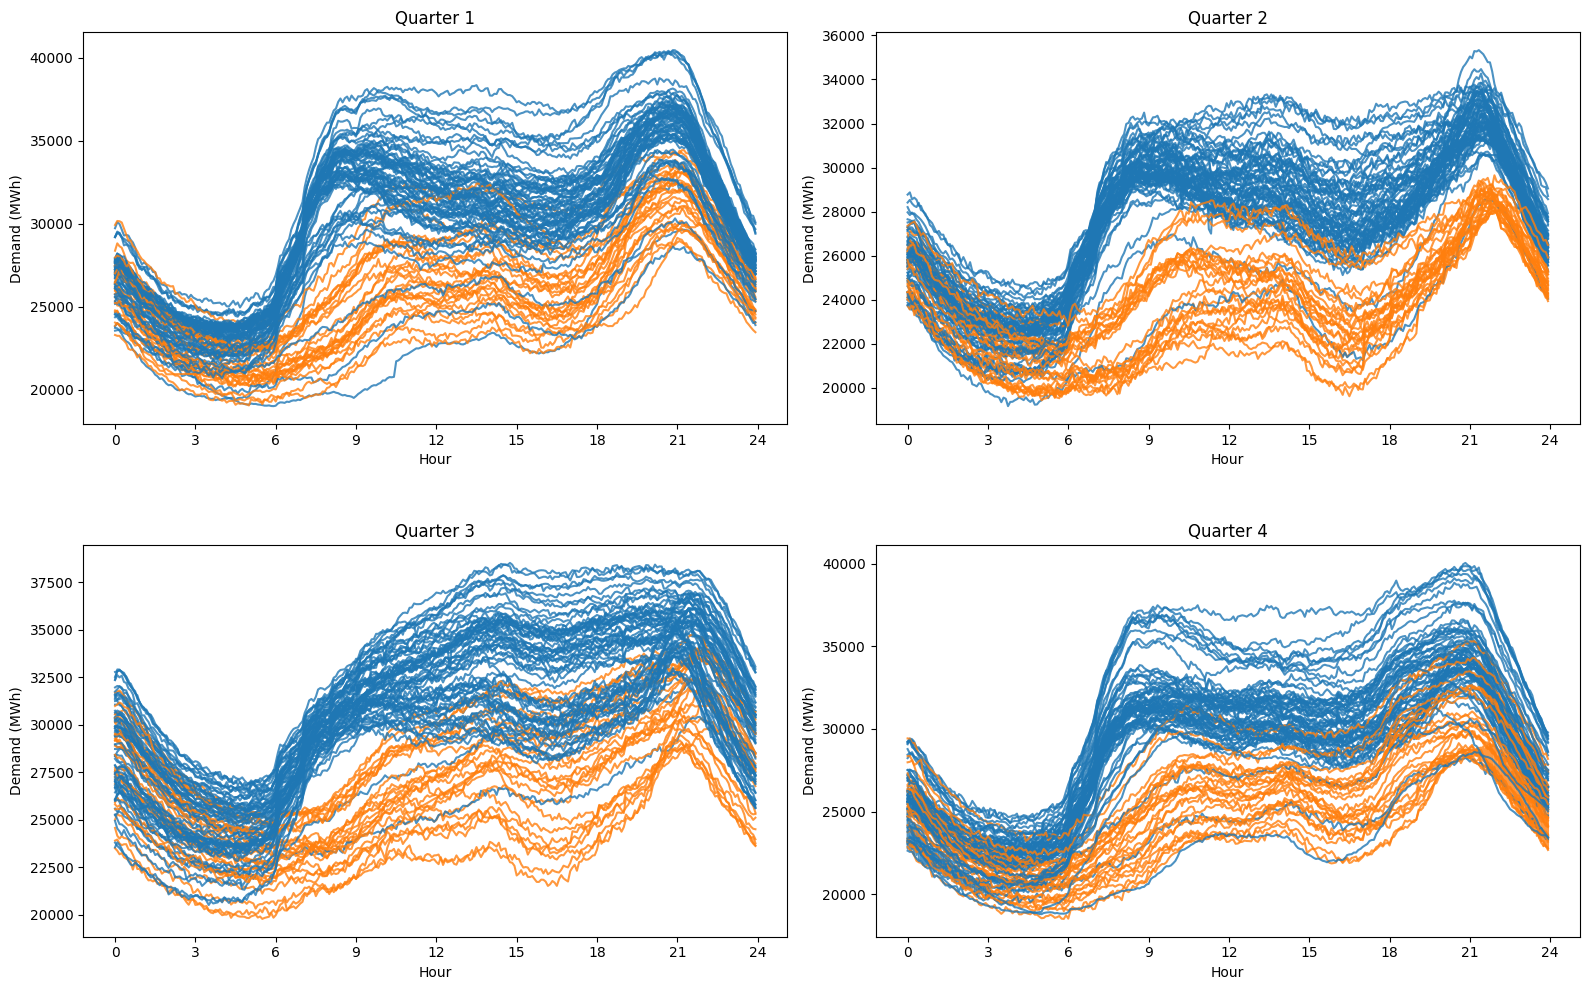

In [26]:
# 确保 datetime 列为 datetime 类型
all_data['datetime'] = pd.to_datetime(all_data['datetime'], format='mixed', errors='coerce')

# 定义工作日和休息日
def is_workday(weekday):
    return 'Workday' if weekday < 5 else 'Weekend'

all_data['quarter'] = all_data['datetime'].dt.to_period('Q')
all_data['date'] = all_data['datetime'].dt.date
all_data['weekday'] = all_data['datetime'].dt.weekday  # 0=Monday, ..., 6=Sunday
all_data['day_type'] = all_data['weekday'].apply(is_workday)
colors = {'Workday': '#1f77b4', 'Weekend': '#ff7f0e'}  # 蓝色/橙色

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for ax, (q, group) in zip(axes, all_data.groupby('quarter')):
    shown = set()
    for day, day_group in group.groupby('date'):
        day_group = day_group.sort_values('datetime')
        day_type = day_group['day_type'].iloc[0]
        x = day_group['datetime'].dt.hour + day_group['datetime'].dt.minute / 60
        label = day_type if day_type not in shown else None
        ax.plot(x, day_group['demand'], color=colors[day_type], alpha=0.8, label=label)
        shown.add(day_type)
    ax.set_title(f'Quarter {q.quarter}')
    ax.set_xlabel('Hour')
    ax.set_ylabel('Demand (MWh)')
    ax.set_xticks(range(0, 25, 3))
plt.tight_layout(h_pad=4)
plt.show()